In [36]:
import os
os.environ['SUMO_HOME'] = '/opt/homebrew/share/sumo'

In [37]:
import traci
from sumo_rl import SumoEnvironment

In [64]:
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

class StepCallback(BaseCallback):
    def __init__(self,max_episodes, verbose=0):
        super(StepCallback, self).__init__(verbose)
        self.max_episodes = max_episodes
        self.current_episode = 0
        self.episode_rewards = []
        self.current_episode_reward = 0
        self.episode_number = 0
        self.step_rewards = []

    def _on_step(self) -> bool:
        # Get the reward for the current step
        rewards = self.locals["rewards"]
        self.current_episode_reward += rewards[0]
        self.step_rewards.append(rewards[0])
        # Check if the episode is done
        done_array = self.locals["dones"]
        if any(done_array):
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_number += 1
            self.current_episode_reward = 0
            
        #self.plot_step_rewards()
        return self.episode_number < self.max_episodes

    def plot_rewards(self):
        plt.plot(self.episode_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Reward ")
        plt.show()
    def plot_step_rewards(self):
        plt.plot(self.step_rewards)
        plt.xlabel("Step")
        plt.ylabel("Reward")
        plt.title("Reward per Step")
        plt.show()


In [39]:
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy



In [40]:
import numpy as np

def minimize_congestion_maximize_throughput_refined(traffic_signal):
    """
    Refined reward function to maximize throughput while reducing congestion in all lanes.
    Args:
        traffic_signal (TrafficSignal): The traffic signal object.
    
    Returns:
        float: The calculated reward.
    """
    # Factor weights
    beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8 = -1, -0.1, -1, -0.5, 2, -0.01, -100, -0.5

    # Total delays for all lanes (sum of delays across all lanes)
    delays = 0
    for lane in traffic_signal.lanes:
        avg_speed = traffic_signal.sumo.lane.getLastStepMeanSpeed(lane)
        speed_limit = traffic_signal.sumo.lane.getMaxSpeed(lane)
        lane_delay = 1 - avg_speed / speed_limit
        delays += lane_delay

    # Total waiting time for all lanes (sum of waiting times across all lanes)
    total_waiting_time = sum(traffic_signal.get_accumulated_waiting_time_per_lane())

    # Total queue length for all lanes (number of vehicles halted in all lanes)
    total_queue_length = traffic_signal.get_total_queued()

    # Phase change penalty
    phase_change = 1 if traffic_signal.is_yellow else 0

    # Total vehicles passing through the intersection (throughput)
    throughput_per_lane = [traffic_signal.sumo.lane.getLastStepVehicleNumber(lane) for lane in traffic_signal.out_lanes]
    total_throughput = sum(throughput_per_lane)

    # Variance of throughput across lanes (to encourage equity)
    throughput_variance = np.var(throughput_per_lane)

    # Total travel time for vehicles passing through the intersection
    total_travel_time = sum(
        traffic_signal.sumo.vehicle.getWaitingTime(vehicle) for lane in traffic_signal.out_lanes
        for vehicle in traffic_signal.sumo.lane.getLastStepVehicleIDs(lane)
    )

    # Intersection blockage penalty based on pressure
    pressure = traffic_signal.get_pressure()
    blockage_penalty = beta7 if pressure > 0 else 0

    # Reward computation based on the weighted sum
    reward = (
        beta1 * delays +
        beta2 * total_waiting_time +
        beta3 * total_queue_length +
        beta4 * phase_change +
        beta5 * total_throughput +
        beta6 * total_travel_time +
        beta7 * blockage_penalty +
        beta8 * throughput_variance  # Penalty for throughput variance
    )

    return reward


In [41]:
import numpy as np

def balanced_traffic_reward(traffic_signal):
    """
    Balanced reward function to maximize throughput while reducing congestion in all lanes.
    This version aims to ensure that the reward converges toward zero by balancing rewards and penalties.
    
    Args:
        traffic_signal (TrafficSignal): The traffic signal object.
    
    Returns:
        float: The calculated reward.
    """
    # Balanced factor weights
    beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8 = -0.1, -0.05, -0.1, -0.05, 0.5, -0.01, -50, -0.1

    # Total delays for all lanes (sum of delays across all lanes)
    delays = 0
    for lane in traffic_signal.lanes:
        avg_speed = traffic_signal.sumo.lane.getLastStepMeanSpeed(lane)
        speed_limit = traffic_signal.sumo.lane.getMaxSpeed(lane)
        lane_delay = 1 - avg_speed / speed_limit
        delays += lane_delay

    # Total waiting time for all lanes (sum of waiting times across all lanes)
    total_waiting_time = sum(traffic_signal.get_accumulated_waiting_time_per_lane())

    # Total queue length for all lanes (number of vehicles halted in all lanes)
    total_queue_length = traffic_signal.get_total_queued()

    # Phase change penalty
    phase_change = 1 if traffic_signal.is_yellow else 0

    # Total vehicles passing through the intersection (throughput)
    throughput_per_lane = [traffic_signal.sumo.lane.getLastStepVehicleNumber(lane) for lane in traffic_signal.out_lanes]
    total_throughput = sum(throughput_per_lane)

    # Variance of throughput across lanes (to encourage equity)
    throughput_variance = np.var(throughput_per_lane)

    # Total travel time for vehicles passing through the intersection
    total_travel_time = sum(
        traffic_signal.sumo.vehicle.getWaitingTime(vehicle) for lane in traffic_signal.out_lanes
        for vehicle in traffic_signal.sumo.lane.getLastStepVehicleIDs(lane)
    )

    # Intersection blockage penalty based on pressure
    pressure = traffic_signal.get_pressure()
    blockage_penalty = beta7 if pressure > 0 else 0

    # Reward computation based on the balanced weighted sum
    reward = (
        beta1 * delays +
        beta2 * total_waiting_time +
        beta3 * total_queue_length +
        beta4 * phase_change +
        beta5 * total_throughput +
        beta6 * total_travel_time +
        blockage_penalty +
        beta8 * throughput_variance  # Penalty for throughput variance
    )

    return reward


In [42]:
def always_red_reward(traffic_signal):
    """
    A reward function that keeps the traffic light always red.
    
    Args:
        traffic_signal (TrafficSignal): The traffic signal object.
    
    Returns:
        float: The calculated reward.
    """
    # Penalty weights
    penalty_phase_change = -100  # Heavy penalty for phase change to green/yellow
    minimal_reward = -1          # Minimal reward to keep lights red
    
    # Determine if the current phase is not red
    current_state = traffic_signal.sumo.trafficlight.getRedYellowGreenState(traffic_signal.id)
    is_not_red = any(c in current_state for c in ['g', 'G', 'y', 'Y'])
    
    # Apply a heavy penalty if not red, otherwise give minimal reward
    if is_not_red:
        reward = penalty_phase_change
    else:
        reward = minimal_reward
    
    return reward


In [65]:
steps_per_episode = 100000
total_episodes = 10
# Environment setup
env = SumoEnvironment(
    net_file="./environments/single-intersection.net.xml",
    route_file="./environments/single-intersection-vhvh.rou.xml",
    out_csv_name="./outputs/dqn",
    single_agent=True,
    reward_fn='diff-waiting-time',
    use_gui=False,
    num_seconds=steps_per_episode,
    begin_time=0
)





Initializing SumoEnvironment
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 0 ACT 0 BUF 0)                      


In [66]:
# Model configuration with moderate exploration
# Instantiate the DQN Model
model = DQN(
    env=env,
    policy=MlpPolicy,                 # Use the MLP policy for DQN
    learning_rate=0.0001,             # Reduced learning rate for stable learning
    learning_starts=1000,             # Start training after 1000 steps
    train_freq=4,                     # Train every 4 steps
    target_update_interval=500,       # Update the target network every 500 steps
    exploration_initial_eps=0.1,      # Initial exploration rate
    exploration_final_eps=0.01,       # Final exploration rate (lower exploration)
    exploration_fraction=0.2,         # Fraction of steps for exploration decay
    verbose=1                         # Verbose output
)

# Instantiate the callback
step_callback = StepCallback(verbose=1, max_episodes=total_episodes)
# Start training with the callback
model.learn(total_timesteps=steps_per_episode*total_episodes, callback=step_callback)
step_callback.plot_step_rewards()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Reset called, episode: 0
 Retrying in 1 seconds
Step #90000.00 (1ms ~= 500.00*RT, ~47500.00UPS, TraCI: 42ms, vehicles TOT 59387 ACT 95 BUF #18000.00 (1ms ~= 1000.00*RT, ~114000.00UPS, TraCI: 42ms, vehicles TOT 10385 ACT 114 000.00 (1ms ~= 1000.00*RT, ~119000.00UPS, TraCI: 41ms, vehicles TOT 22187 ACT 119 00 (2ms ~= 500.00*RT, ~46500.00UPS, TraCI: 44ms, vehicles TOT 33627 ACT 93 BUF2ms ~= 500.00*RT, ~33000.00UPS, TraCI: 29ms, vehicles TOT 46466 ACT 66 BUFReset called, episode: 1
Step #100000.00 (1ms ~= 1000.00*RT, ~91000.00UPS, TraCI: 42ms, vehicles TOT 66869 ACT 91 BU
 Retrying in 1 seconds


KeyboardInterrupt: 

16


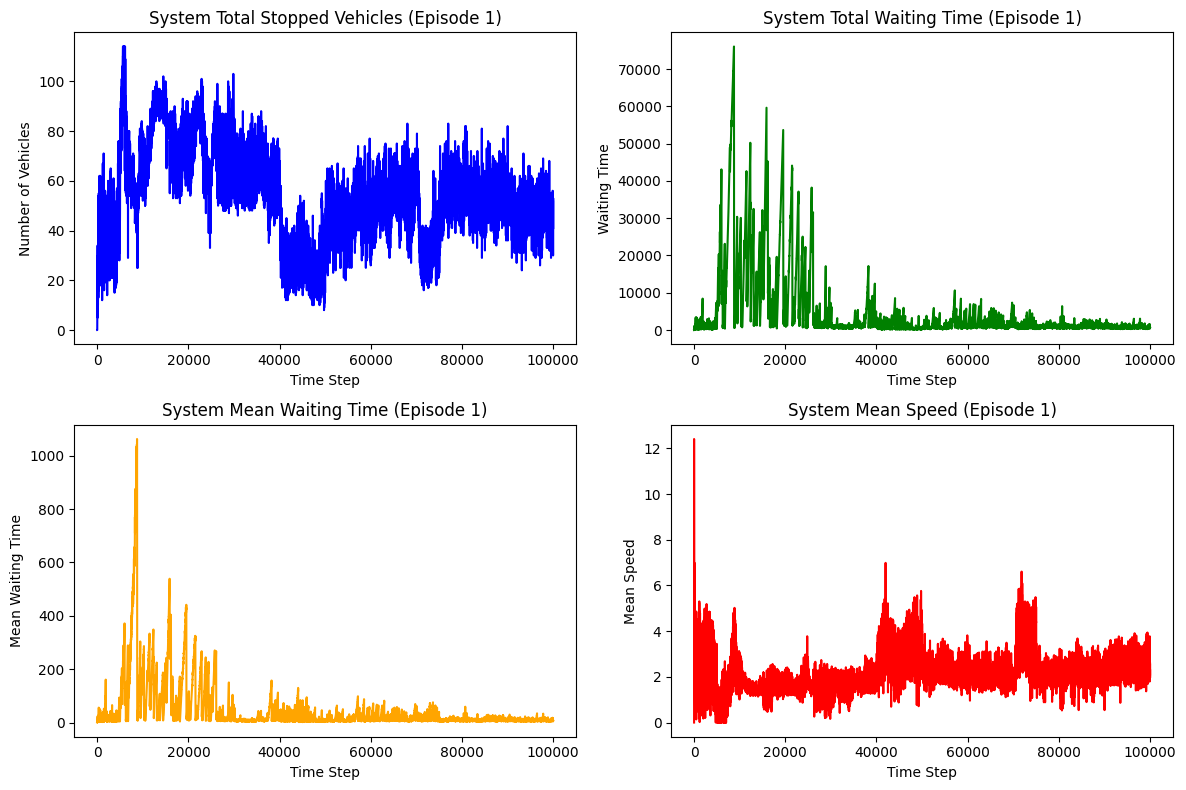

In [67]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to the output directory
output_dir = './outputs'

# Iterate through each CSV file and create a graph for each episode
for filename in sorted(os.listdir(output_dir)):
    if filename.startswith('dqn_conn19_ep') and filename.endswith('.csv'):
        file_path = os.path.join(output_dir, filename)
        df = pd.read_csv(file_path)

        # Extract the episode number from the filename
        episode_num = filename.split('_ep')[1].split('.csv')[0]

        # Plot relevant graphs using the episode DataFrame
        plt.figure(figsize=(12, 8))

        # Plot system total stopped vehicles
        plt.subplot(2, 2, 1)
        plt.plot(df['step'], df['system_total_stopped'], color='blue')
        plt.title('System Total Stopped Vehicles (Episode {})'.format(episode_num))
        plt.xlabel('Time Step')
        plt.ylabel('Number of Vehicles')

        # Plot system total waiting time
        plt.subplot(2, 2, 2)
        plt.plot(df['step'], df['system_total_waiting_time'], color='green')
        plt.title('System Total Waiting Time (Episode {})'.format(episode_num))
        plt.xlabel('Time Step')
        plt.ylabel('Waiting Time')

        # Plot system mean waiting time
        plt.subplot(2, 2, 3)
        plt.plot(df['step'], df['system_mean_waiting_time'], color='orange')
        plt.title('System Mean Waiting Time (Episode {})'.format(episode_num))
        plt.xlabel('Time Step')
        plt.ylabel('Mean Waiting Time')

        # Plot system mean speed
        plt.subplot(2, 2, 4)
        plt.plot(df['step'], df['system_mean_speed'], color='red')
        plt.title('System Mean Speed (Episode {})'.format(episode_num))
        plt.xlabel('Time Step')
        plt.ylabel('Mean Speed')

        plt.tight_layout()
        plt.savefig(f'./outputs/episode_{episode_num}_graphs.png')
        plt.show()


40000
